# Project - Sarcasm detection
***
Иван Јорданов 181122

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [ ]:
import pandas as pd
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json',lines=True)
import re
df['source'] = df['article_link'].apply(lambda x: re.findall(r'\w+', x)[2])
df.head()

,is_sarcastic,headline,article_link,source
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,theonion
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,theonion


In [ ]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
source          0
dtype: int64

In [ ]:
del df['article_link']

In [ ]:
df.head()

,is_sarcastic,headline,source
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep. totally nails why congress is falling...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar from getting t...,theonion
4,1,mother comes pretty close to using word 'strea...,theonion


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


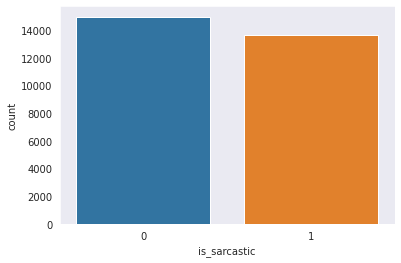

In [ ]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df['headline']=df['headline'].str.lower()
# Code to remove the Hashtags from the text
df['headline']=df['headline'].apply(lambda x:re.sub(r'\B#\S+','',x))
# Code to remove the links from the text
df['headline']=df['headline'].apply(lambda x:re.sub(r"http\S+", "", x))
# Code to remove the Special characters from the text 
df['headline']=df['headline'].apply(lambda x:' '.join(re.findall(r'\w+', x)))
# Code to substitute the multiple spaces with single spaces
df['headline']=df['headline'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
# Code to remove all the single characters in the text
df['headline']=df['headline'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Remove the twitter handlers
df['headline']=df['headline'].apply(lambda x:re.sub('@[^\s]+','',x))

In [ ]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['headline'] = df['headline'].apply(remove_stopwords)
df.head()

,is_sarcastic,headline,source
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep totally nails congress falling short g...,huffingtonpost
2,0,eat veggies 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar getting work,theonion
4,1,mother comes pretty close using word streaming...,theonion


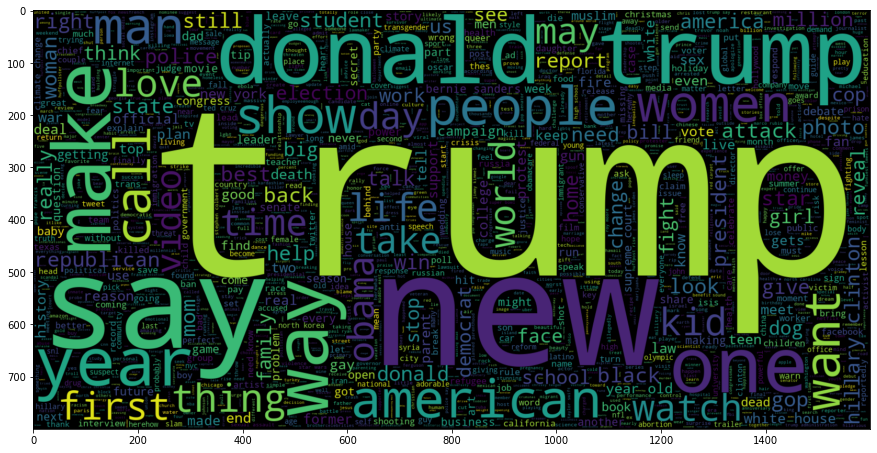

In [ ]:
plt.figure(figsize = (15,15)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

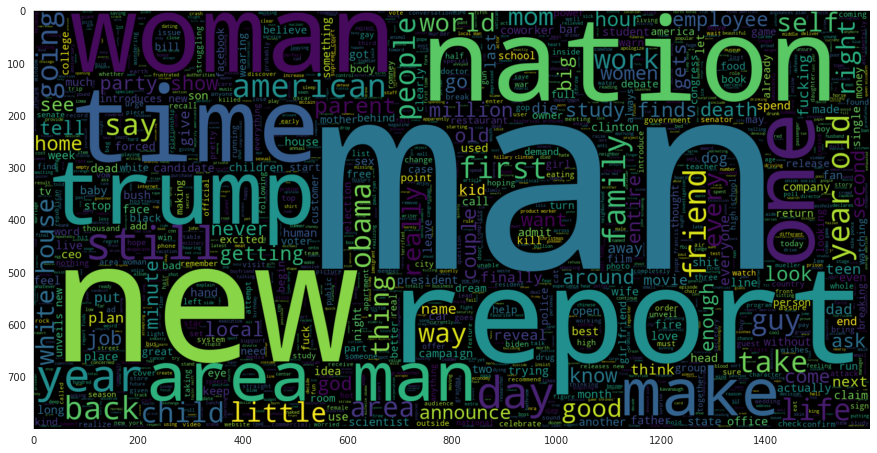

In [ ]:
plt.figure(figsize = (15,15)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

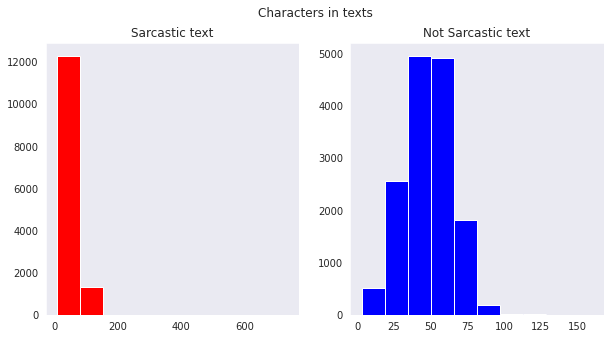

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='blue')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

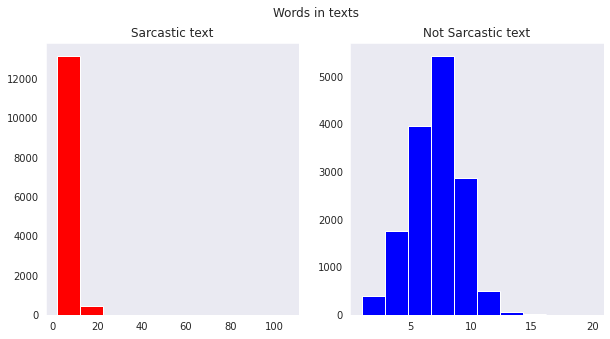

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='blue')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

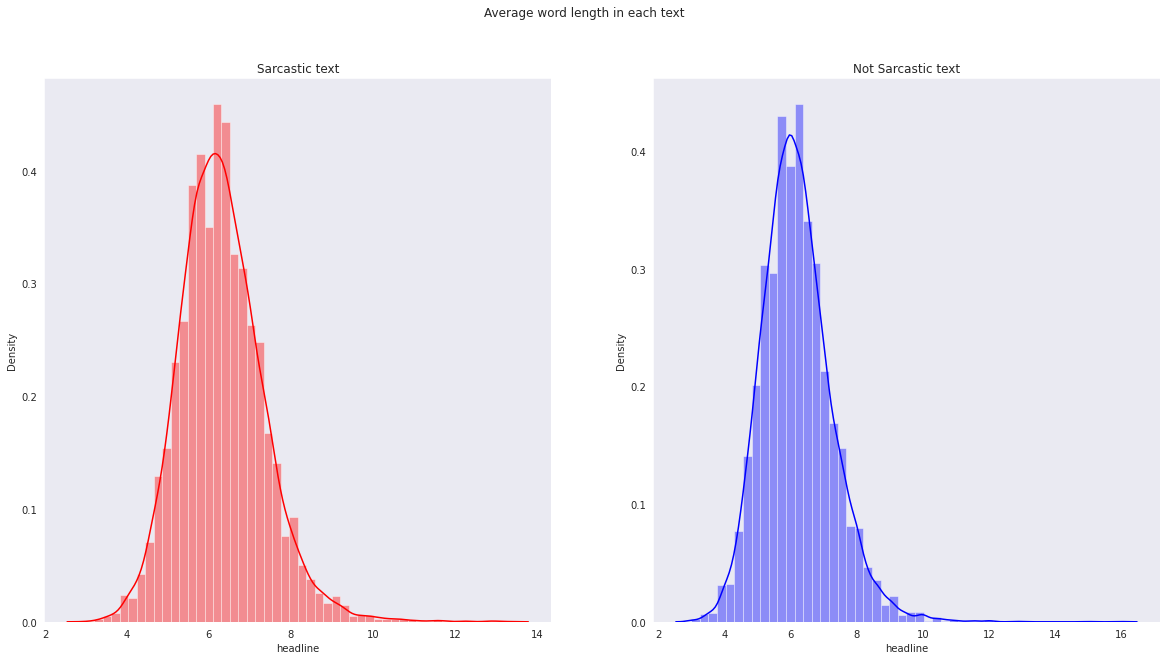

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='blue')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [ ]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['tokenized'] = df['headline'].apply(lambda x: tokenization(x.lower()))
df.head()

,is_sarcastic,headline,source,tokenized
0,1,thirtysomething scientists unveil doomsday clo...,theonion,"[thirtysomething, scientists, unveil, doomsday..."
1,0,dem rep totally nails congress falling short g...,huffingtonpost,"[dem, rep, totally, nails, congress, falling, ..."
2,0,eat veggies 9 deliciously different recipes,huffingtonpost,"[eat, veggies, 9, deliciously, different, reci..."
3,1,inclement weather prevents liar getting work,theonion,"[inclement, weather, prevents, liar, getting, ..."
4,1,mother comes pretty close using word streaming...,theonion,"[mother, comes, pretty, close, using, word, st..."


In [ ]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['headline'] = df['headline'].apply(stemm_text)
df.head()

,is_sarcastic,headline,source
0,1,thirtysometh scientist unveil doomsday clock h...,theonion
1,0,dem rep total nail congress fall short gender ...,huffingtonpost
2,0,eat veggi 9 delici differ recip,huffingtonpost
3,1,inclement weather prevent liar get work,theonion
4,1,mother come pretti close use word stream correct,theonion


In [ ]:
import plotly.express as px

In [ ]:
all_words=[]
for i in range(len(df['tokenized'])):
    a=df['tokenized'][i]
    for i in a:
        all_words.append(i)
all_words=pd.Series(np.array(all_words))

common_words=all_words.value_counts()[:100].rename_axis('Common Words').reset_index(name='count')

fig = px.treemap(common_words, path=['Common Words'], values='count',template= "plotly_dark",title='100 Most Common Words In Headline')
fig.show()

In [ ]:
#Cluster
import tensorflow as tf

import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
from absl import logging

In [ ]:
# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(df.headline.values)

In [ ]:
message_embeddings

<tf.Tensor: shape=(28619, 512), dtype=float32, numpy=
array([[-0.00396715, -0.04207516, -0.02365268, ..., -0.01629005,
        -0.04349859, -0.05253571],
       [-0.0397876 , -0.06715164, -0.00190306, ...,  0.00498404,
        -0.04597426,  0.02213218],
       [-0.07162774, -0.07264467,  0.04931975, ...,  0.07355273,
        -0.00163657, -0.02628609],
       ...,
       [-0.04886784, -0.04497722, -0.0108022 , ...,  0.00164615,
         0.02500729, -0.08625693],
       [ 0.00732713, -0.05633419, -0.05345391, ...,  0.00938985,
        -0.03418679, -0.03530646],
       [ 0.07962629,  0.03116965,  0.04677119, ...,  0.03014849,
        -0.01113798, -0.06379712]], dtype=float32)>

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3)
km.fit(message_embeddings)
clusters = km.labels_.tolist()

In [ ]:
from sklearn.decomposition import PCA
import numpy as np


data = message_embeddings
pca = PCA(2)
 
#Transform the data
df_new = pca.fit_transform(data)

In [ ]:
#Initialize the class object
kmeans = KMeans(n_clusters=3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df_new)
 
#Getting unique labels
u_labels = np.unique(label)
 
labels = kmeans.labels_

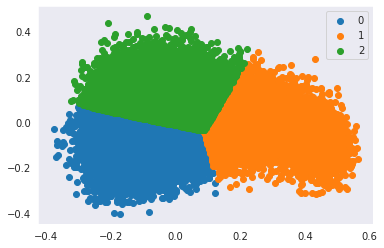

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#plotting the results:
for i in u_labels:
    plt.scatter(df_new[label == i , 0] , df_new[label == i , 1] , label = i)
plt.legend()
plt.show()

## XGB
***

### Data split

In [ ]:
#Spliting it into training and testing 
X = df['headline']
y = df['is_sarcastic']

# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.2,random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

22895 22895
5724 5724


### Defining the model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
    ))
])
from sklearn import metrics

# Fit the pipeline with the data
MODEL = pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

### Evaluating the model

In [ ]:
print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

Train: 0.6850404018344617
Test: 0.6673654786862334


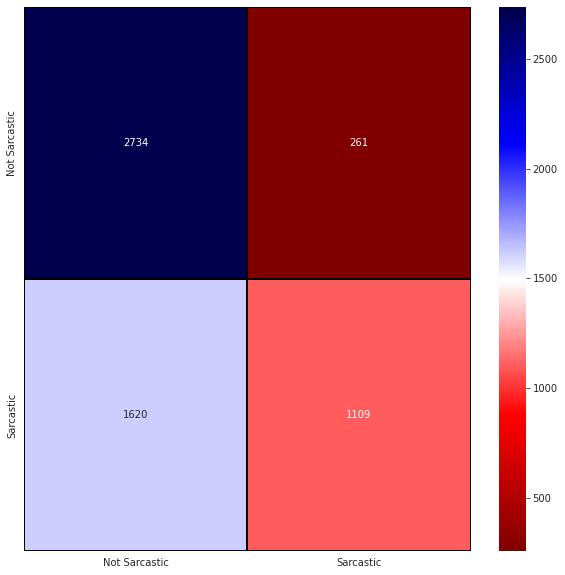

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred_class)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "seismic_r", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' ,
            xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

## RNN

### Data preprocess for the model

In [ ]:
#Getting X and Y ready
from sklearn.preprocessing import LabelEncoder
X = df.headline
Y = df.is_sarcastic
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

### Datsa split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

### Processing the data for the model

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### Defining the RNN structure for the model

In [ ]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

### Compiling the model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

### Fitting the model on training data

In [ ]:
from keras.callbacks import EarlyStopping
model.fit(sequences_matrix,Y_train,batch_size=100,epochs=5,
          validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/5
207/207 [==============================] - 39s 167ms/step - loss: 0.5739 - accuracy: 0.6936 - val_loss: 0.5198 - val_accuracy: 0.7345
Epoch 2/5
207/207 [==============================] - 32s 155ms/step - loss: 0.5029 - accuracy: 0.7497 - val_loss: 0.5249 - val_accuracy: 0.7297


### Testing

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

### Accuracy

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

179/179 [==============================] - 7s 40ms/step - loss: 0.5400 - accuracy: 0.7226
Test set
  Loss: 0.540
  Accuracy: 0.723


## Word2Vec
***

In [ ]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysometh', 'scientist', 'unveil', 'doomsday', 'clock', 'hair', 'loss'],
 ['dem',
  'rep',
  'total',
  'nail',
  'congress',
  'fall',
  'short',
  'gender',
  'racial',
  'equal'],
 ['eat', 'veggi', '9', 'delici', 'differ', 'recip'],
 ['inclement', 'weather', 'prevent', 'liar', 'get', 'work'],
 ['mother', 'come', 'pretti', 'close', 'use', 'word', 'stream', 'correct']]

In [ ]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [ ]:
#vocab size
len(w2v_model.wv.vocab)

25171

In [ ]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 200)           5034400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 256)          336896    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,427,041
Trainable params: 5,427,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [ ]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
157/157 [==============================] - 106s 594ms/step - loss: 0.5551 - acc: 0.7052 - val_loss: 0.4346 - val_acc: 0.7980
Epoch 2/3
157/157 [==============================] - 86s 547ms/step - loss: 0.2155 - acc: 0.9173 - val_loss: 0.5141 - val_acc: 0.7760
Epoch 3/3
157/157 [==============================] - 86s 549ms/step - loss: 0.0899 - acc: 0.9677 - val_loss: 0.6878 - val_acc: 0.7753


In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 25s 40ms/step - loss: 0.0377 - acc: 0.9897
Accuracy of the model on Training Data is -  98.97169470787048
269/269 [==============================] - 7s 26ms/step - loss: 0.6878 - acc: 0.7753
Accuracy of the model on Testing Data is -  77.53319144248962


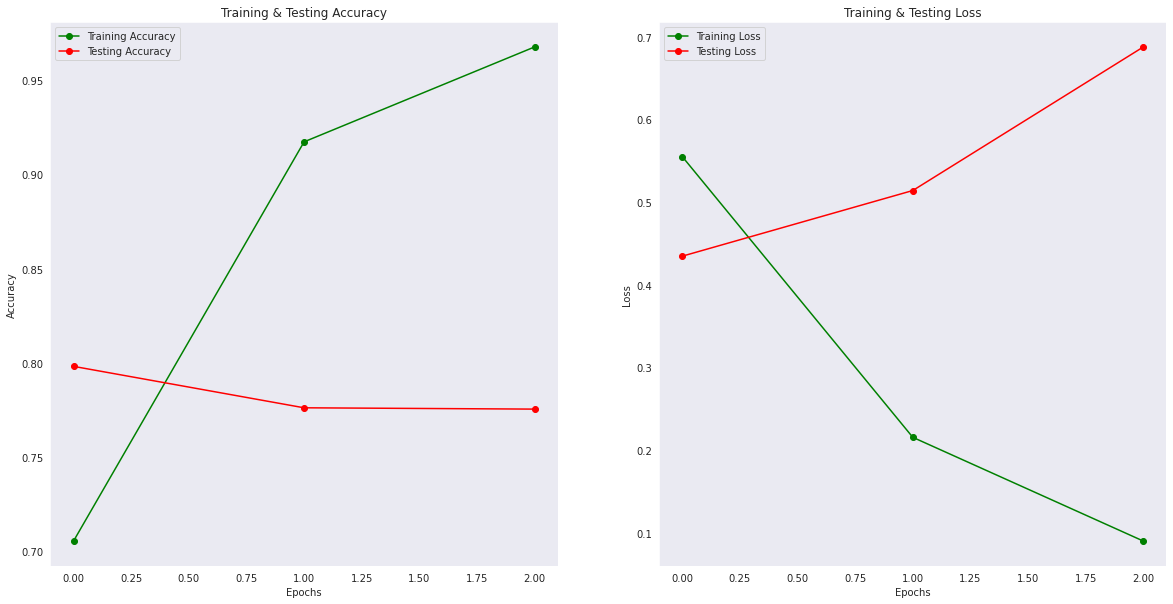

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## Conclusion
***
Според резултатите, алгоритамот Word2Vec испадна најдобар, но, со понатамошна анализа на Word2Vec со графовите прикажани погоре за Accuracy и Loss, моделот прави overfitting на test множеството.
Па затоа, најдобар модел е моделот RNN, со прецизност 0.72.

Според тоа што го учевме на предавања, RNN (Recurent Neural Network) поради нивната внатрешна меморија, може да запамти важни работи за влезот што им овозможува да бидат многу прецизни во предвидување на она што следува.